<a href="https://colab.research.google.com/github/kty3452/ML-Class/blob/main/week9/TSLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === 1. 데이터 불러오기 ===
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TSLA.csv')

# 필요 컬럼만 사용
data = data[['Open', 'High', 'Low', 'Close']]

# === 2. 정규화 ===
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled, columns=data.columns)

# === 3. 윈도우 시퀀스 생성 ===
window = 3   # 최근 3행 사용 → 다음 행의 Close 예측

X, y = [], []
for i in range(len(scaled_df) - window):
    X.append(scaled_df.iloc[i:i+window].values)   # (3, 4)
    y.append(scaled_df.iloc[i+window]['Close'])   # 다음 행의 Close

X, y = np.array(X), np.array(y)
print("입력 X shape:", X.shape, " / 타깃 y shape:", y.shape)
# === 4. 시계열 분할 (Train / Val / Test) ===
n = len(X)
train_end = int(n * 0.7)
val_end   = int(n * 0.9)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val     = X[train_end:val_end], y[train_end:val_end]
X_test, y_test   = X[val_end:], y[val_end:]

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# === 5. 모델 정의 함수 ===
def build_rnn(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(64, input_shape=input_shape),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=input_shape),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


입력 X shape: (2953, 3, 4)  / 타깃 y shape: (2953,)
Train: 2067, Val: 590, Test: 296


In [9]:

# === 6. 모델 학습 ===
input_shape = (window, 4)

rnn_model = build_rnn(input_shape)
lstm_model = build_lstm(input_shape)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True
)

rnn_history = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=8, verbose=1,
    callbacks=[early_stop]
)

lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, batch_size=8, verbose=0,
    callbacks=[early_stop]
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7712e-05 - val_loss: 4.3883e-04
Epoch 2/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9772e-06 - val_loss: 6.7998e-04
Epoch 3/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.2565e-06 - val_loss: 2.5590e-04
Epoch 4/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3095e-06 - val_loss: 5.6449e-04
Epoch 5/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.0602e-06 - val_loss: 2.1800e-04
Epoch 6/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8690e-06 - val_loss: 3.8377e-04
Epoch 7/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8007e-06 - val_loss: 2.0991e-04
Epoch 8/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3901e-06 - val_loss: 2.9120e-04
Epoch 9/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9295e-06 - val_loss: 1.4738e-04
Epoch 10/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3614e-06 - val_loss: 2.1936e-04
Epoch 11/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4609e-0

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[RNN] MSE=2786.73, MAE=38.39, R²=0.8966
[LSTM] MSE=1819.36, MAE=30.01, R²=0.9325


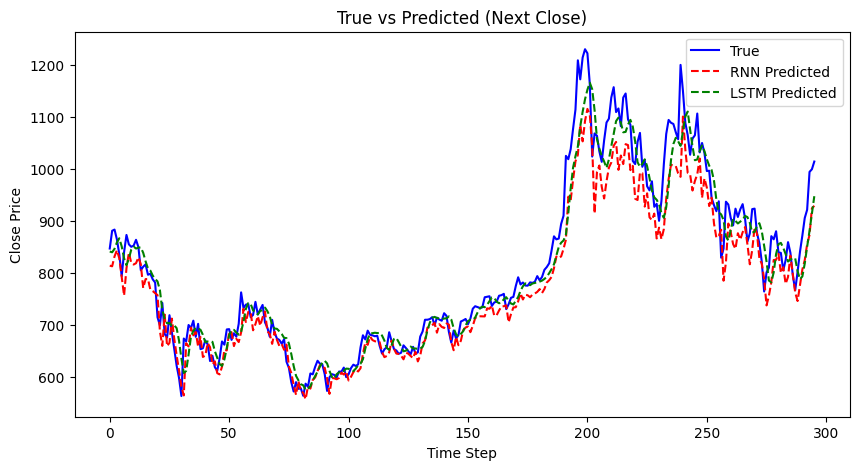

In [10]:
# === 7. 예측 ===
pred_rnn = rnn_model.predict(X_test)
pred_lstm = lstm_model.predict(X_test)

# === 8. 역정규화 (Close만 복원) ===
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
y_true = close_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_rnn = close_scaler.inverse_transform(pred_rnn)
y_pred_lstm = close_scaler.inverse_transform(pred_lstm)

# === 9. 성능 평가 함수 ===
def evaluate_model(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"[{name}] MSE={mse:.2f}, MAE={mae:.2f}, R²={r2:.4f}")
    return mse, mae, r2

evaluate_model(y_true, y_pred_rnn, "RNN")
evaluate_model(y_true, y_pred_lstm, "LSTM")

# === 10. 결과 시각화 ===
plt.figure(figsize=(10,5))
plt.plot(y_true, label='True', color='blue')
plt.plot(y_pred_rnn, label='RNN Predicted', color='red', linestyle='--')
plt.plot(y_pred_lstm, label='LSTM Predicted', color='green', linestyle='--')
plt.title('True vs Predicted (Next Close)')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()